# Modelo de clasificación por tipo de espacio

### Importaciones

In [62]:
import numpy as np
import os
import PIL
import sklearn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import seaborn as sn
import pandas as pd
from datetime import datetime
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

### Construcción de dataset

In [34]:
#Preprocesamiento de los datos
directory="E:/TesisMA/DatosF2/No_Amoblado"
#directory1="E:/TesisMA/Datos/DataB"
img_height=256
img_width=256
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width))


Found 543 files belonging to 2 classes.
Using 435 files for training.
Found 543 files belonging to 2 classes.
Using 108 files for validation.


### Analisis del dataset

In [35]:
class_names = train_ds.class_names
print(class_names)
num_classes = 2

['1', '2']


[195, 240]


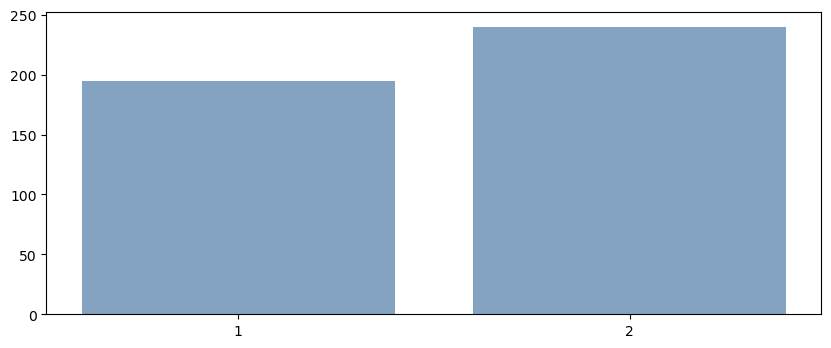

In [36]:
y = np.concatenate([y for x, y in train_ds], axis=0)
labels = list(y)
elements_per_class = []
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
for i in range(0,num_classes):
    elements_per_class.append(labels.count(i))
print(elements_per_class)
plt.bar(class_names,elements_per_class,color=(0.2, 0.4, 0.6, 0.6));

108


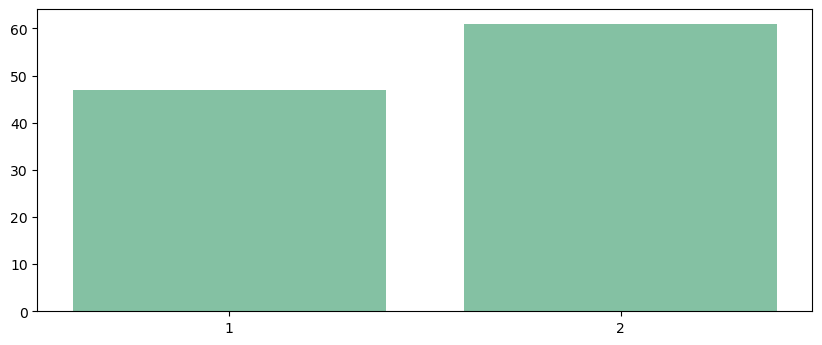

In [37]:
labels1 = np.concatenate([y for x, y in val_ds], axis=0)
labels1 = list(labels1)
elements_per_class1 = []
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
for i in range(0,num_classes):
    elements_per_class1.append(labels1.count(i))
print(sum(elements_per_class1))
plt.bar(class_names,elements_per_class1,color=(0.2, 0.6, 0.4, 0.6));

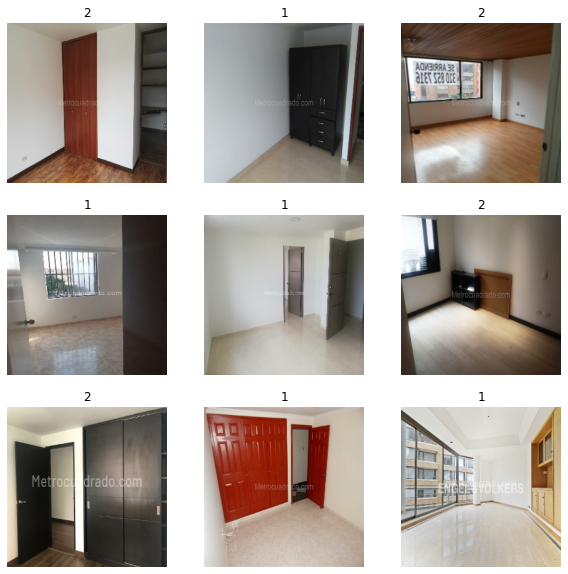

In [38]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [41]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data augmentation

In [42]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

### CNN

In [43]:
model = Sequential([
  #Capa para realizar data augmantation
  data_augmentation,
  #Priemera capa entrada de 256x256 x3 canales de color
  layers.experimental.preprocessing.Rescaling(1/255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  #layers.BatchNormalization(),
  layers.Dense(128,activation="relu", kernel_initializer="he_normal"),
  #layers.BatchNormalization(),
  layers.Dense(64,activation="relu", kernel_initializer="he_normal"),
  #layers.BatchNormalization(),
  layers.Dense(1, activation='sigmoid')
])

### LRF Finder

In [44]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)       

In [46]:
checkpoint_filepath="E:/TesisMA/Modelos/F2/No_Amoblado/Calidad_No_Amoblado"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [47]:
epochs=80
history = model.fit(
train_ds,
validation_data=val_ds,
epochs=epochs,
callbacks=[model_checkpoint_callback]
)

Epoch 1/80
14/14 [==============================] - 21s 1s/step - loss: 0.7035 - accuracy: 0.5425 - val_loss: 0.6618 - val_accuracy: 0.5926
INFO:tensorflow:Assets written to: E:/TesisMA/Modelos/F2/No_Amoblado\Calidad_No_Amoblado\assets
Epoch 2/80
14/14 [==============================] - 16s 1s/step - loss: 0.6521 - accuracy: 0.6391 - val_loss: 0.6428 - val_accuracy: 0.6759
INFO:tensorflow:Assets written to: E:/TesisMA/Modelos/F2/No_Amoblado\Calidad_No_Amoblado\assets
Epoch 3/80
14/14 [==============================] - 16s 1s/step - loss: 0.6549 - accuracy: 0.6138 - val_loss: 0.6435 - val_accuracy: 0.5833
Epoch 4/80
14/14 [==============================] - 16s 1s/step - loss: 0.6477 - accuracy: 0.6069 - val_loss: 0.6486 - val_accuracy: 0.5741
Epoch 5/80
14/14 [==============================] - 16s 1s/step - loss: 0.6362 - accuracy: 0.6322 - val_loss: 0.6141 - val_accuracy: 0.6111
Epoch 6/80
14/14 [==============================] - 16s 1s/step - loss: 0.5928 - accuracy: 0.6690 - val_loss

14/14 [==============================] - 16s 1s/step - loss: 0.4219 - accuracy: 0.8368 - val_loss: 0.4267 - val_accuracy: 0.8148
Epoch 56/80
14/14 [==============================] - 16s 1s/step - loss: 0.4257 - accuracy: 0.8276 - val_loss: 0.4222 - val_accuracy: 0.8056
Epoch 57/80
14/14 [==============================] - 17s 1s/step - loss: 0.4390 - accuracy: 0.8069 - val_loss: 0.4535 - val_accuracy: 0.7963
Epoch 58/80
14/14 [==============================] - 16s 1s/step - loss: 0.4415 - accuracy: 0.8161 - val_loss: 0.4287 - val_accuracy: 0.8056
Epoch 59/80
14/14 [==============================] - 17s 1s/step - loss: 0.4526 - accuracy: 0.7954 - val_loss: 0.4340 - val_accuracy: 0.7870
Epoch 60/80
14/14 [==============================] - 17s 1s/step - loss: 0.4382 - accuracy: 0.8046 - val_loss: 0.4498 - val_accuracy: 0.7963
Epoch 61/80
14/14 [==============================] - 16s 1s/step - loss: 0.4362 - accuracy: 0.8069 - val_loss: 0.4340 - val_accuracy: 0.8148
Epoch 62/80
14/14 [======

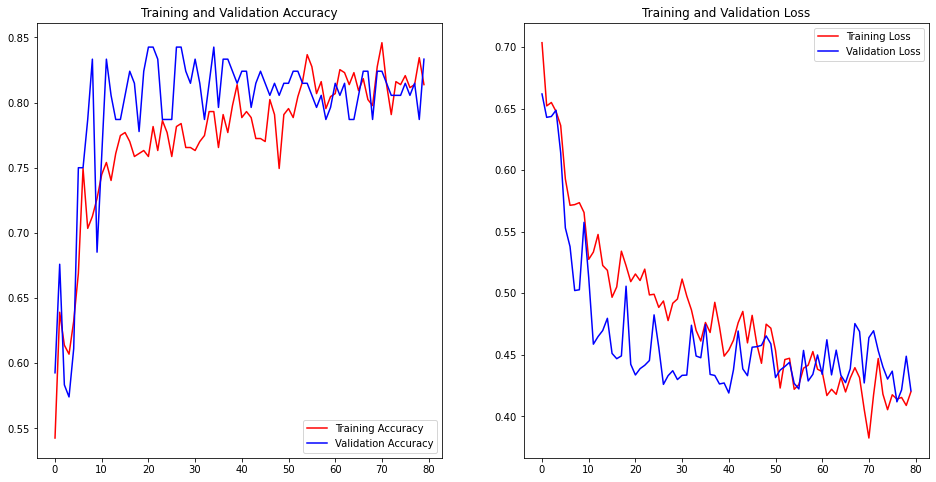

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

sn.set_palette(sn.color_palette("husl", 2))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy',color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss',color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss',color='blue')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Curva ROC

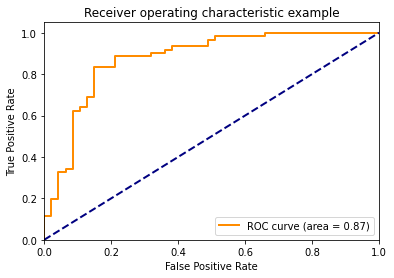

In [49]:
# Cargar mejor modelo 
model = tf.keras.models.load_model(checkpoint_filepath)

predictions = model.predict(val_ds)
labels= np.concatenate([y for x, y in val_ds], axis=0)
# Compute ROC curve and ROC area for each class

fpr, tpr, thresholds = roc_curve(labels, predictions)
roc_auc = auc(fpr, tpr)



plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [50]:
from numpy import argmax
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.692292


#### Confusion matrix

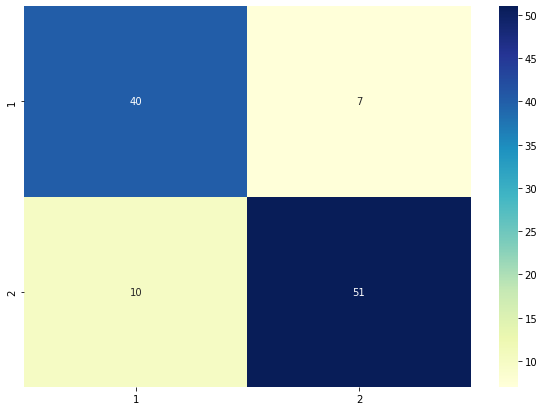

In [78]:
predictions = np.where(model.predict(val_ds)>=best_thresh,1,0)
matriz = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
df_cm = pd.DataFrame(matriz, index = class_names, columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="YlGnBu",  fmt='g');

In [80]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82        47
           1       0.88      0.84      0.86        61

    accuracy                           0.84       108
   macro avg       0.84      0.84      0.84       108
weighted avg       0.84      0.84      0.84       108

